In [1]:
import time
import numpy as np
import pandas as pd
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from collections import Counter, defaultdict
import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

In [3]:
v_data, e_data, v_sets, e_sets, core_targets, ext_targets, core_testing = utils.load_for_jupyter()

Dataset already downloaded. Loading it from file system
LOADING DATA: 1.12 s
PREPROCESSING: 1.11 s


In [27]:
# subsample
# do the embedding on only the nodes with testingFlag = 0 and the edges connected to those nodes

sub_nodes = v_data.loc[v_data.testingFlag == 0]
sub_edges = e_data[e_data.from_id.isin(sub_nodes.index)]
sub_edges = sub_edges[sub_edges.to_id.isin(sub_nodes.index)]

In [30]:
v_sets, e_sets = utils.preprocess_data(sub_nodes, sub_edges)

PREPROCESSING: 0.10 s


In [31]:
# drop testingFlag
for i in v_sets:
    v_sets[i] = v_sets[i].drop('testingFlag', axis=1)

Account :
0.0    13769
Name: testingFlag, dtype: int64
Address :
0.0    1568
Name: testingFlag, dtype: int64
Customer :
0.0    13650
Name: testingFlag, dtype: int64
Derived Entity :
0.0    3925
Name: testingFlag, dtype: int64
External Entity :
0.0    4757
Name: testingFlag, dtype: int64


In [177]:
for i in v_sets:
    v_sets[i] = v_sets[i].drop('ExtendedCaseGraphID', axis=1)

In [178]:
batch_size = 200
epochs = 30
num_samples = [8, 4]
dropout = 0.4
hinsage_layer_sizes = [32, 32]

In [179]:
G = sg.StellarDiGraph(v_sets, e_sets)

In [180]:
generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

def make_hinsage():
    return HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'relu'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

hinsage = make_hinsage()

In [181]:
def run_deep_graph_infomax(base_model, generator, epochs):
    t0 = time.time()
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    t1 = time.time()
    print(f'Time required: {t1-t0:.2f} s ({(t1-t0)/60:.1f} min)')
    
    return x_emb_in, x_emb_out, model

Epoch 1/30
69/69 [==============================] - 8s 110ms/step - loss: 0.5680 0s - loss: 
Epoch 2/30
69/69 [==============================] - 8s 110ms/step - loss: 0.4088
Epoch 3/30
69/69 [==============================] - 7s 106ms/step - loss: 0.3267
Epoch 4/30
69/69 [==============================] - 8s 110ms/step - loss: 0.2717
Epoch 5/30
69/69 [==============================] - 7s 101ms/step - loss: 0.2424 3s - loss: 0 - ETA: 3s - loss:  - ETA: - ETA: 1s - l
Epoch 6/30
69/69 [==============================] - 7s 104ms/step - loss: 0.2256
Epoch 7/30
69/69 [==============================] - 7s 101ms/step - loss: 0.2160 
Epoch 8/30
69/69 [==============================] - 7s 102ms/step - loss: 0.2014 1s - loss: 0.20 - ETA: 1s - loss: - ETA: 1s - l
Epoch 9/30
69/69 [==============================] - 7s 100ms/step - loss: 0.1929 0s - loss: 0
Epoch 10/30
69/69 [==============================] - 7s 104ms/step - loss: 0.1824- ETA: 3s -  -
Epoch 11/30
69/69 [=============================

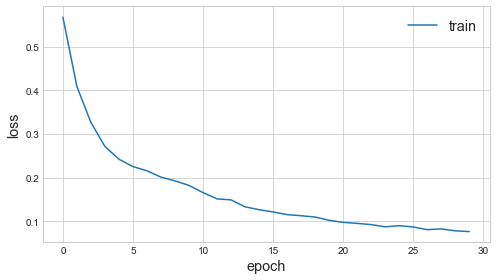

In [182]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

In [183]:
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
train_cv_embs = emb_model.predict(
    generator.flow(v_sets['Account'].index.values)
)
train_cv_embs_2d = pd.DataFrame(
    TSNE(n_components=2).fit_transform(train_cv_embs), 
    index=v_sets['Account'].index.values
)

In [184]:
# Coloring based on ExtendedCaseGraphID

# these are the training+cv indexes
node_ids = v_sets['Account'].index.values.tolist()

# these are the training+cv Extended case ID
ext_targets_2 = v_data.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets_2), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_2]

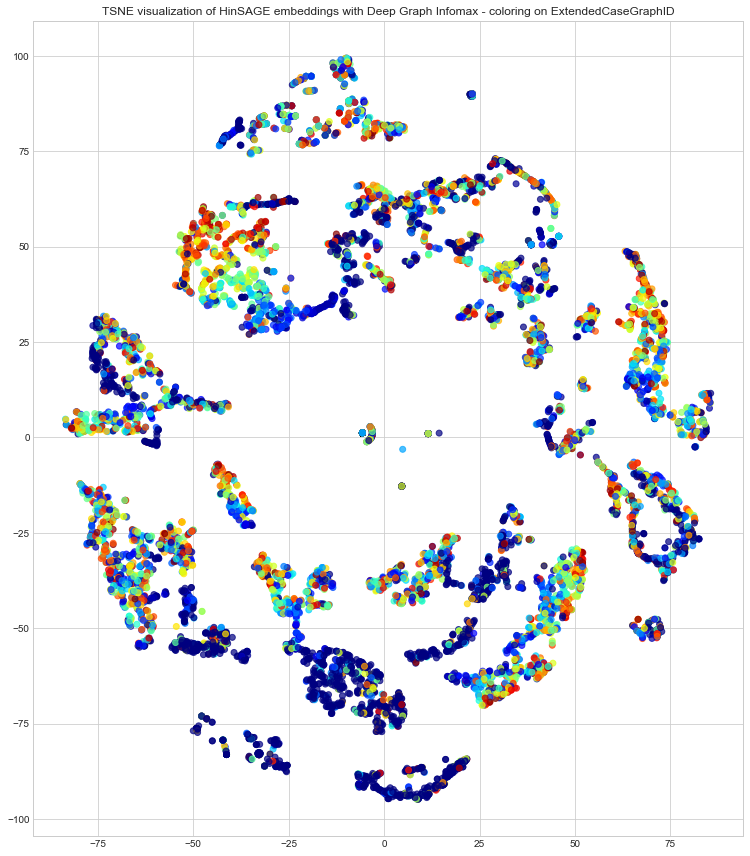

In [185]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring on ExtendedCaseGraphID")
plt.show()

In [186]:
# account core case ID based coloring

# these are the training+cv core case IDs
ext_targets_5 = v_data.loc[[int(node_id) for node_id in node_ids]]['CoreCaseGraphID']

label_map = {l: i*100 for i, l in enumerate(np.unique(ext_targets_5), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_5]

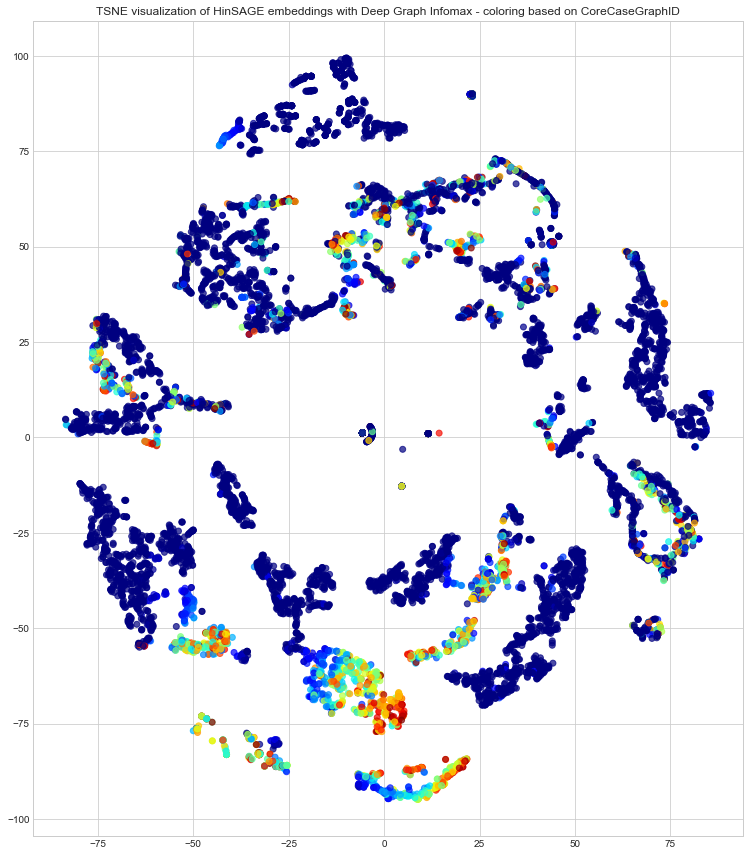

In [187]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring based on CoreCaseGraphID")
plt.show()

In [188]:
train_set = train_cv_embs[:10000]
train_labels = np.ravel(pd.DataFrame(ext_targets_2.values[:10000]).fillna(0))

cv_set = train_cv_embs[-3769:]
cv_labels = np.ravel(pd.DataFrame(ext_targets_2.values[-3769:]).fillna(0))

In [189]:
train_set_new = train_set
train_labels_new = train_labels
train_set_map = np.where(v_sets['Account'][:10000].CoreCaseGraphID != 0, True, False)
for i in range(len(train_set)):
    train_set_new[i] = train_set_new[i] if train_set_map[i] == True else np.NaN
    train_labels_new[i] = train_labels_new[i] if train_set_map[i] == True else np.NaN
train_set_new = pd.DataFrame(train_set_new).dropna()
train_labels_new = np.ravel(pd.DataFrame(train_labels_new).dropna())

In [190]:
sample_weights = np.ones(10000)
sample_weights_map = np.where(v_sets['Account'][:10000].ExtendedCaseGraphID == 0, True, False)
for i in range(len(sample_weights)):
    sample_weights[i] = 1 if sample_weights_map[i] == False else 0.005

AttributeError: 'DataFrame' object has no attribute 'ExtendedCaseGraphID'

In [ ]:
# these 2983 embeddings are the ones of the training nodes that have corecaseID = 0

In [ ]:
sample_weights = np.ones(len(train_set_new))
train_set_map_ext = np.where(train_labels_new != 0, True, False)
for i in range(len(train_set_new)):
    sample_weights[i] = 1 if train_set_map[i] == False else 1/2983

In [ ]:
classifier = LogisticRegression(
    max_iter=500,
    solver='lbfgs'
)

# alternate between tset and tset_new with different sam weights
classifier.fit(
    X=train_set,
    y=train_labels,
    #sample_weight=sample_weights,
)

In [ ]:
# do the same for the CV set

cv_set_new = cv_set
cv_labels_new = cv_labels
cv_set_map = np.where(v_sets['Account'][-3769:].CoreCaseGraphID != 0, True, False)
for i in range(len(cv_set)):
    cv_set_new[i] = cv_set_new[i] if cv_set_map[i] == True else np.NaN
    cv_labels_new[i] = cv_labels_new[i] if cv_set_map[i] == True else np.NaN
cv_set_new = pd.DataFrame(cv_set_new).dropna()
cv_labels_new = np.ravel(pd.DataFrame(cv_labels_new).dropna())

In [ ]:
cv_pred = classifier.predict(cv_set_new)
f1_avg = f1_score(cv_labels_new, cv_pred, average='micro')
acc = (cv_pred == cv_labels_new).mean()

print(f"f1: {f1_avg:.3f} - acc: {acc:.3f}")

In [ ]:
np.unique(cv_pred)